# DASHBOARD CREATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from datetime import timedelta
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
# Create the main application window
root = tk.Tk()
root.title("Forecast Dashboard")

''

In [3]:
# Create a Notebook widget for tabs
notebook = ttk.Notebook(root)
notebook.pack(fill='both', expand=True)

# Store & Load dataframe for Modelling
Since modeling is time consuming it is advisable to store the prepared data in order to avoid running through the code again and again when Kernel needs to be restarted or cleared.

In [4]:
# LOAD!!!
import pandas as pd

df = pd.read_csv('./data/cleanedProjectTweets.csv')

In [5]:
# Set up datatypes

# Formating 'date' column to 'YYYY-MM-DD'
df['date'] = pd.to_datetime(df['date'])
#df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.drop('text', axis=1,inplace=True) #df['text'].astype('string')
df.drop('cleaned_text', axis=1,inplace=True) #df['cleaned_text'].astype('string')

df['preprocessed_text'] = df['preprocessed_text'].astype('string')
df['sentiment'] = df['sentiment'].astype('string')

#df.reset_index(drop=True, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598285 entries, 0 to 1598284
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1598285 non-null  datetime64[ns]
 1   preprocessed_text  1590126 non-null  string        
 2   sentiment          1598285 non-null  string        
dtypes: datetime64[ns](1), string(2)
memory usage: 36.6 MB


In [7]:
df.drop_duplicates(keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

#### `Check Empty texts` after preprocessing

In [8]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.preprocessed_text = df.preprocessed_text.str.strip()

# Removing rows with empty 'text'
df = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')]

df.reset_index(drop=True, inplace=True)

In [9]:
# Filter out rows where 'TextColumn' has only one character or none
df = df[~df['preprocessed_text'].apply(lambda x: len(str(x)) <= 1)]
df.reset_index(drop=True, inplace=True)

In [10]:
df.drop_duplicates(subset=['preprocessed_text'],keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

# Sentiment over a time period

To analyze changes in sentiment over a specific time period, the column `date` and `sentiment` data are used.

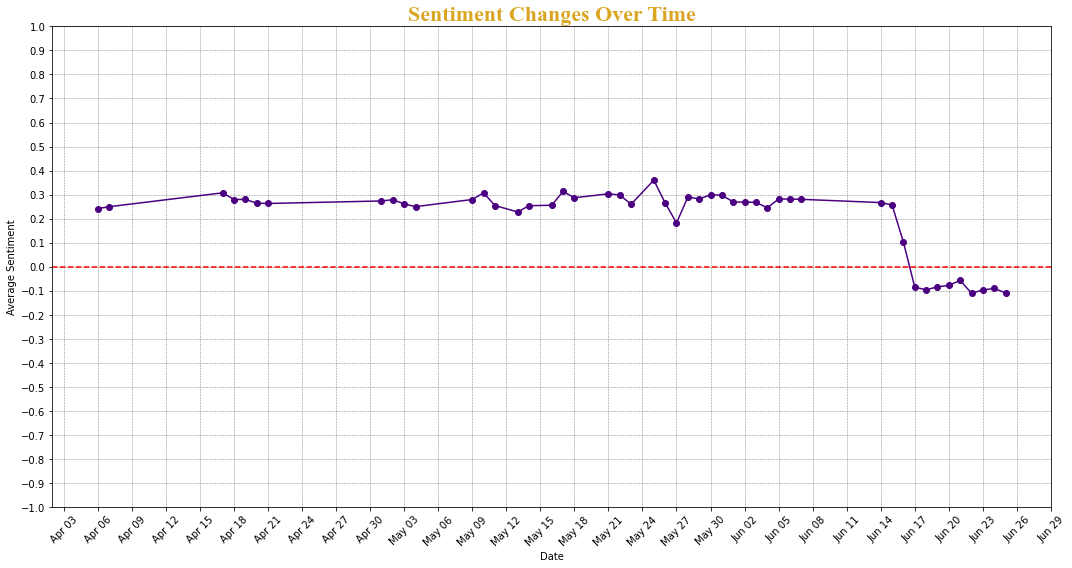

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Date Conversion to datetime format
df['date'] = pd.to_datetime(df['date'])
# Extracting date from the timestamp
df['date'] = df['date'].dt.date

# Mapping sentiment to numerical values
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
df['sentiment_value'] = df['sentiment'].map(sentiment_mapping)

# Groupping by date & Calculating the average sentiment
date_grouped = df.groupby('date')['sentiment_value'].mean()

# Sentiment Changes over time
fig_sent = plt.figure(figsize=(15, 8))
plt.plot(date_grouped.index, date_grouped.values, marker='o',color='indigo')
plt.title('Sentiment Changes Over Time',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman")
plt.xlabel('Date')
plt.ylabel('Average Sentiment')

plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Formatting x-axis tick as "month day" format with 3 day interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Setting y-axis tick interval to 0.1
plt.yticks([i/10 for i in range(-10, 11)])

# Horizontal line at y=0 (Neutral Zone)
plt.axhline(y=0, color='red', linestyle='--')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As seen above the overall Sentiment of the tweets are positive up to around **June 17th** from which point they remain negative.

# ADD TAB TO DASHBOARD!!!

In [12]:
def createTab(FIG, TEXT):
    # TAB Creation for SAMPLE plot
    tab_to_create= tk.Frame(notebook)
    notebook.add(tab_to_create, text=TEXT)
    
    # CANVAS Creation to display Figure in TAB
    canvas_sample = FigureCanvasTkAgg(FIG, master=tab_to_create)
    canvas_sample.get_tk_widget().pack()
    
    # figure SIZE UPDATE based on TAB size
    def update_figure_size(event):
        width = frame_arima.winfo_width()  # Get tab width
        height = frame_arima.winfo_height()  # Get tab height
        fig_arima.set_size_inches(width / 100, height / 100)
        canvas.draw()

    # Bind the resize event to the function
    tab_to_create.bind("<Configure>", update_figure_size)    

In [13]:
createTab(fig_sent, "sentiment")

# Forecasting

## Prophet
It's a forecasting method designed to handle time series data with various components including trends, seasonality, and holidays. It's a more user-friendly and automated approach compared to traditional methods like ARIMA. Prophet is efficient with data that has strong seasonal components and multiple contributing factors.

In [14]:
#!pip install --upgrade pip
#!pip install prophet
#!conda install -c conda-forge prophet

In [15]:
from prophet import Prophet
from datetime import timedelta

In [16]:
# Prepare data for Prophet
df_prophet = df.rename(columns={'date': 'ds', 'sentiment_value': 'y'})

In [17]:
# Prophet Model Loading
import pickle
import joblib

# Model Loading using pickle
#model_filename = 'prophet_model_pickle.pkl'
#with open(model_filename, 'rb') as f:
#    loaded_model = pickle.load(f)
    
# Load the model using joblib
model_filename = 'prophet_model_joblib.pkl'
model_filename = 'prophet_model.pkl'
model = joblib.load(model_filename)

In [18]:
# Generating future dates for forecasting
#future_3_month = model.make_future_dataframe(periods=90)
future_3_month = model.make_future_dataframe(periods=90)#, yearly_seasonality=False, daily_seasonality=False)

In [19]:
# TAKES A LONG TIME TO RUN!!!!
# Make forecasts for 3 months
forecast_3_month = model.predict(future_3_month)

In [20]:
df_prophet['ds']

0          2009-04-06
1          2009-04-06
2          2009-04-06
3          2009-04-06
4          2009-04-06
              ...    
1469840    2009-06-16
1469841    2009-06-16
1469842    2009-06-16
1469843    2009-06-16
1469844    2009-06-16
Name: ds, Length: 1469845, dtype: object

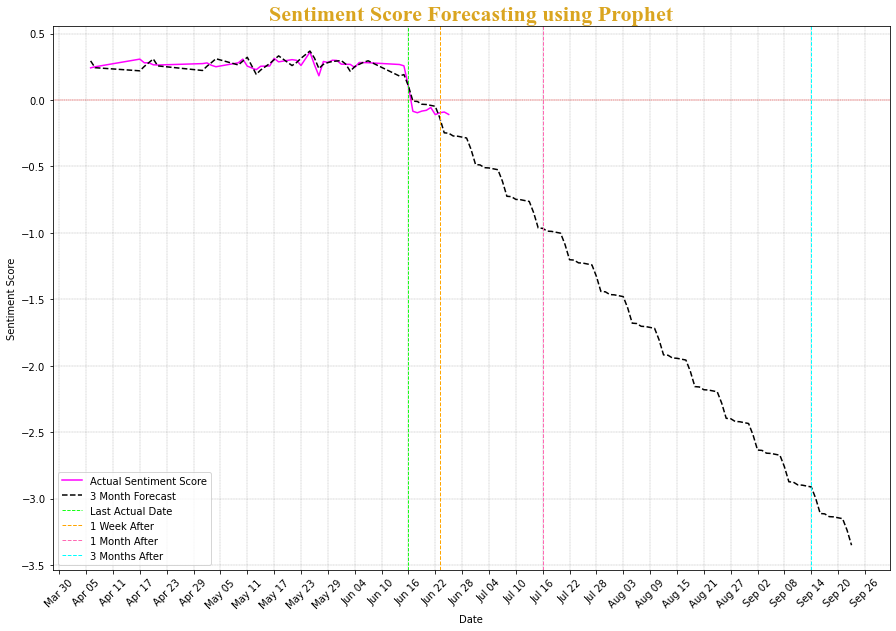

In [21]:
from datetime import timedelta

FIG_PROPHET = plt.figure(figsize=(15, 10))
plt.plot(df_prophet.groupby('ds')['y'].mean().reset_index()['ds'], df_prophet.groupby('ds')['y'].mean().reset_index()['y'], label='Actual Sentiment Score'
        ,color='magenta')
#plt.plot(forecast_week['ds'], forecast_week['yhat'], label='1 Week Forecast', linestyle='dashed')
plt.plot(forecast_3_month['ds'], forecast_3_month['yhat'], label='3 Month Forecast', linestyle='dashed',
        color='black')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Forecasting using Prophet',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman")


# Formatting x-axis tick as "month day" format with 3 day interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))

# Adding vertical lines to signify last actual day, 1 week, 1 month and 3 month forecasting
plt.axvline(x=df_prophet.at[df_prophet['ds'].index[-1], 'ds'], color='lime', linestyle='--', label='Last Actual Date',linewidth=0.9)
plt.axvline(x=df_prophet.at[df_prophet['ds'].index[-1], 'ds'] + timedelta(days=7), color='orange', linestyle='--', label='1 Week After',linewidth=1)
plt.axvline(x=df_prophet.at[df_prophet['ds'].index[-1], 'ds'] + timedelta(days=30), color='hotpink', linestyle='--', label='1 Month After',linewidth=1)
plt.axvline(x=df_prophet.at[df_prophet['ds'].index[-1], 'ds'] + timedelta(days=90), color='aqua', linestyle='--', label='3 Months After',linewidth=1)

# Horizontal line at y=0 (Neutral Zone)
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.4)


plt.xticks(rotation=45)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.show()

# ADD TAB TO DASHBOARD!!!

In [22]:
createTab(FIG_PROPHET, "Prophet")

## ARIMA 

It's a common time series forecasting method that captures autocorrelation and seasonality patterns in a time series data. It is efficient when the data exhibits clear trends and seasonality patterns that can be captured by the model. It's particularly effective when the data doesn't have complex non-linear relationships or external factors affecting it.

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

In [24]:
# Sorting the DataFrame by Date:
df.groupby('date')['sentiment_value'].mean().reset_index().set_index("date").sort_index(inplace=True)
df.sort_index(inplace=True)

In [25]:
# Verifying the Monotonicity of the Index
print(df.index.is_monotonic_increasing)

True


In [26]:
# SAVE only model required data --- SPEED UP MODEL!!!
df_arima = df[["date","sentiment_value"]]

In [27]:
df_arima['date'] = pd.to_datetime(df_arima['date'])

# Set the 'date' column as the index
df_arima.set_index('date', inplace=True)

C:\Users\Foltos\AppData\Local\Temp\ipykernel_3804\2872739499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arima['date'] = pd.to_datetime(df_arima['date'])


In [28]:
daily_df = df_arima.resample('D').mean().fillna(method='ffill')

In [29]:
# Train & Test Splitting
train_size = int(len(daily_df) * 0.8)

# TRAIN ON FIRST 80% of DATA --- GIVES A STRAIGHT LINE FORECAST!!!
#train, test = daily_df.iloc[:train_size], daily_df.iloc[train_size:]

# TRAIN ON LAST 80% of DATA ---- MORE ACCURATE PREDICTION!!!
train, test = daily_df.iloc[train_size:], daily_df.iloc[:train_size]

### Load Model!!!

In [30]:
# ARIMA Model Loading

#import pickle
#model_filename = 'arima_model_pickle.pkl'
# Model Loading using pickle
#with open(model_filename, 'rb') as f:
#    loaded_model = pickle.load(f)
    
#########################################################################    
import joblib   
model_fit = joblib.load('arima_model_job.pkl')    

In [31]:
# Forecasting 3 months ahead 
forecast_steps = 90
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for theforecast with frequency (D - daily, M - monthly...) 
forecast_dates = pd.date_range(start=test.index[-1] + timedelta(days=1), periods=forecast_steps, freq='D')

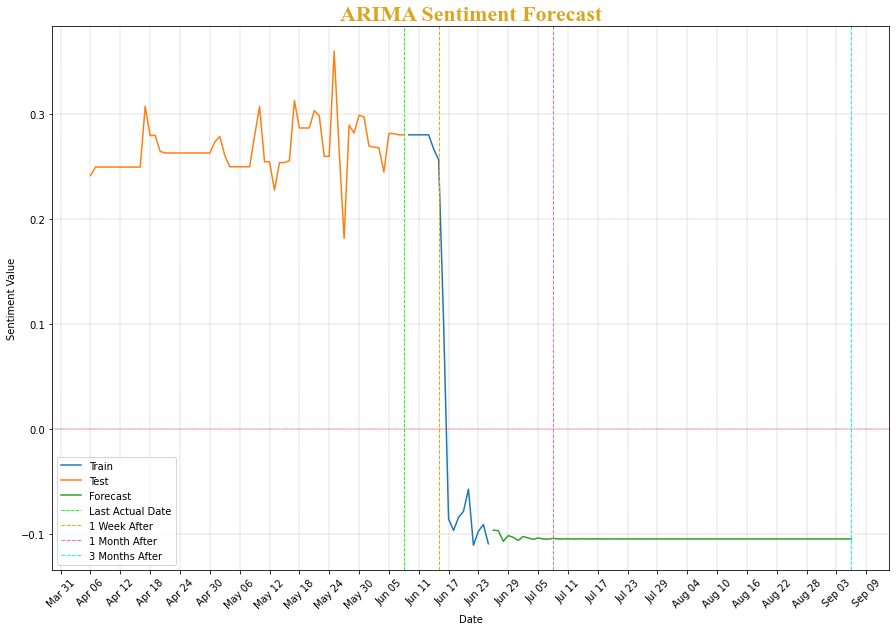

In [32]:
# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame({'forecast': forecast}, index=forecast_dates)

# Forecast Visualization
FIG_ARIMA = plt.figure(figsize=(15, 10))

plt.plot(train.index, train['sentiment_value'], label='Train')
plt.plot(test.index, test['sentiment_value'], label='Test')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Sentiment Value')
plt.title('ARIMA Sentiment Forecast',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman")

# Formatting x-axis tick as "month day" format with 3 day interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))

# Adding vertical lines to signify last actual day, 1 week, 1 month and 3 month forecasting
plt.axvline(x=test.index[-1], color='lime', linestyle='--', label='Last Actual Date',linewidth=0.9)
plt.axvline(x=test.index[-1] + timedelta(days=7), color='orange', linestyle='--', label='1 Week After',linewidth=1)
plt.axvline(x=test.index[-1] + timedelta(days=30), color='hotpink', linestyle='--', label='1 Month After',linewidth=1)
plt.axvline(x=test.index[-1] + timedelta(days=90), color='aqua', linestyle='--', label='3 Months After',linewidth=1)

# Horizontal line at y=0 (Neutral Zone)
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.4)

plt.xticks(rotation=45)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.show()

# ADD TAB TO DASHBOARD!!!

In [33]:
createTab(FIG_ARIMA, "ARIMA")

# RUN DASHBOARD

In [34]:
# Run the main event loop
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Foltos\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Foltos\AppData\Local\Temp\ipykernel_3804\1905715920.py", line 12, in update_figure_size
    width = frame_arima.winfo_width()  # Get tab width
NameError: name 'frame_arima' is not defined
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Foltos\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Foltos\AppData\Local\Temp\ipykernel_3804\1905715920.py", line 12, in update_figure_size
    width = frame_arima.winfo_width()  # Get tab width
NameError: name 'frame_arima' is not defined
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Foltos\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Foltos\AppData\Local\Temp\ipykernel_3804\1905